<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/Sunspot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 65kB/s 
     |████████████████████████████████| 450kB 44.5MB/s 
     |████████████████████████████████| 3.8MB 42.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3ae4805b80cbb185b14b4a72c836d653ae55adba6915a401b00e3aa31f1471ee
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation

In [25]:
import tensorflow as tf
print (tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
#función para graficar
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Tiempo")
  plt.ylabel("Valor")
  plt.grid(True)

In [0]:
#create a function to do the prediction
def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast
 
 def trend (time,slope=0):
  return slope*time

def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time <0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

def seasonality (time, period, amplitude=1,phase=0):
  """Repeats the same pattern at each period"""
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
  rnd=np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time=np.arange(4*365+1,dtype="float32")
baseline=10
series=trend(time,0.1)
baseline=10
amplitude=40
slope=0.05
noise_level=5

#ceate the series
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
#update with noise
series +=noise(time,noise_level,seed=42)

split_time=22
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

#linnear regresion
window_size=20
batch_size=82
shuffle_buffer_size=1000


In [46]:
#importar los datos

import csv
time_step = []
Datos_TRM = []

with open('Datos_TRM.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    Datos_TRM.append(float(row[1]))
    time_step.append(int(row[0]))

series = np.array(Datos_TRM)
time = np.array(time_step)
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [2397.35 2441.1  2407.29 2374.72 2381.91]
time: [1 2 3 4 5]


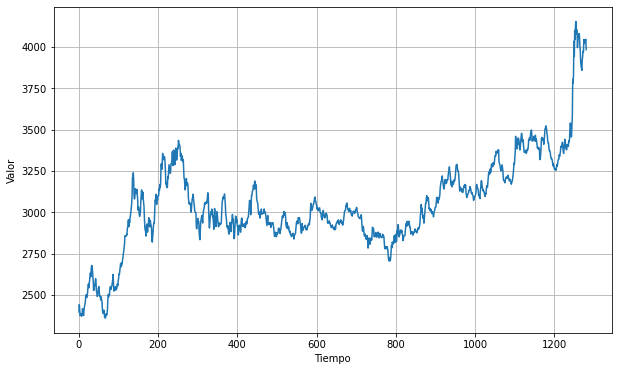

In [47]:
#explorar datos graficamente
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
#preparar el Dataset
split_time = 1198
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size=20
batch_size=82
shuffle_buffer_size=100

In [0]:
#función para escoger parte de los datos
def windowed_dataset(series,window_size,batch_size,shuffle_buffer): #crear un dataset
  dataset=tf.data.Dataset.from_tensor_slices(series) #create a dataset
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)#to slice the data up into the appropriate windows
  dataset=dataset.flat_map(lambda window: window.batch(window_size+1))#flatten the data out flatened into chunksin the suze of our window_size+1
  dataset=dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1])) #shuflet it, choosing smaller number speeds
  dataset=dataset.batch(batch_size).prefetch(1)#size parameter =2 corresponde Yb
  return dataset

In [51]:
dataset=windowed_dataset(x_train,window_size,batch_size, shuffle_buffer_size)

split_time=1218
window_size=20

model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(20,input_shape=[window_size],activation="relu"),
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1), #neurona de salida
])

#lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(lr=1e-7,momentum=0.9)

model.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mae"])
model.fit(dataset,epochs=100,verbose=0)#100,callbacks=[lr_schedule]) history=

ValueError: ignored

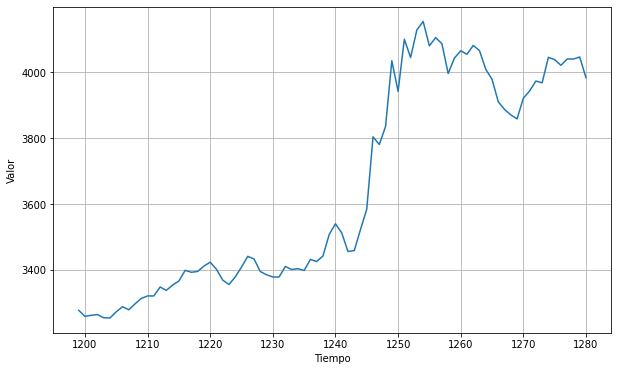

In [43]:
forecast=[] #forecast Vs DAta
#results=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)


In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

InvalidArgumentError: ignored

OPción mas demorada

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 series = tf.expand_dims(series, axis=-1)
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size + 1))
 ds = ds.shuffle(shuffle_buffer)
 ds = ds.map(lambda w: (w[:-1], w[1:]))
 return ds.batch(batch_size).prefetch(1)

In [11]:
#crear el dataset de entrenamiento usando la función windowed_dataset
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)#datos

(3000,)


In [12]:
#Creando el Modelo
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
#predecir el siguiente valor
model.predict(series[3205:3235][np.newaxis])

In [13]:
#compilar y entrenar el modelo
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer,
 metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
12/12 [==============================] - 8s 703ms/step - loss: 50.2223 - mae: 50.9528
Epoch 2/500
12/12 [==============================] - 5s 401ms/step - loss: 33.7533 - mae: 34.1844
Epoch 3/500
12/12 [==============================] - 5s 403ms/step - loss: 27.2566 - mae: 27.7606
Epoch 4/500
12/12 [==============================] - 5s 405ms/step - loss: 24.7191 - mae: 25.1638
Epoch 5/500
12/12 [==============================] - 5s 403ms/step - loss: 22.7620 - mae: 23.2628
Epoch 6/500
12/12 [==============================] - 5s 403ms/step - loss: 21.4559 - mae: 21.9732
Epoch 7/500
12/12 [==============================] - 5s 402ms/step - loss: 20.5303 - mae: 21.1164
Epoch 8/500
12/12 [==============================] - 5s 402ms/step - loss: 20.3958 - mae: 20.8405
Epoch 9/500
12/12 [==============================] - 5s 402ms/step - loss: 19.8023 - mae: 20.3662
Epoch 10/500
12/12 [==============================] - 5s 413ms/step - loss: 19.8333 - mae: 20.3729
Epoch 11/500
12/12 

<Figure size 432x288 with 0 Axes>

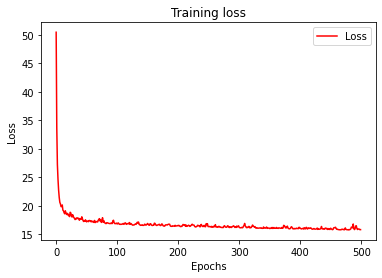

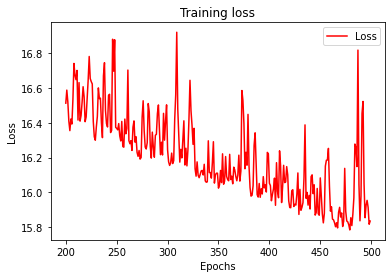

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()


zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
#create a function to do the prediction
def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast

In [0]:
#predict forecast
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

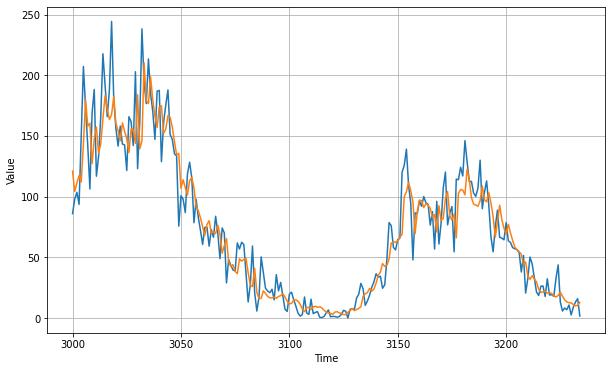

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.011567